# Quantum Phase Estimation on the Hubbard molecule

We would like to study the "Hubbard dimer" molecule, whose Hamiltonian reads:

$$H=-t\sum_{\sigma=\uparrow,\downarrow}\left(c_{1\sigma}^{\dagger}c_{2\sigma}+c_{2\sigma}^{\dagger}c_{1\sigma}\right)-\mu\sum_{i=1,2}\sum_{\sigma=\uparrow,\downarrow}n_{i\sigma}+U\sum_{i=1,2}n_{i\uparrow}n_{i\downarrow}$$

with $n_{i\sigma} = c^\dagger_{i\sigma} c_{i\sigma}$. We will choose $\mu=U/2$ to keep the number of electrons at one per site.

## Defining the Hubbard dimer Hamiltonian

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import itertools
from qat.fermion.hamiltonians import make_hubbard_model

U = 1.0
t = 0.2
t_mat = -t * np.array([[0.0, 1.0], [1.0, 0.0]])
hamilt = make_hubbard_model(t_mat, U, mu=U / 2)

eigvals = np.linalg.eigvalsh(hamilt.get_matrix())

np.set_printoptions(precision=4, suppress=True)
print("All the eigenenergies are")
print(eigvals, end="\n")

All the eigenenergies are
[-1.1403 -1.     -1.     -1.     -0.7    -0.7    -0.7    -0.7    -0.3
 -0.3    -0.3    -0.3     0.      0.      0.      0.1403]


## Performing phase estimation

In [2]:
from qat.qpus import get_default_qpu
from qat.fermion.phase_estimation import perform_phase_estimation

qpu = get_default_qpu()

nqbits_phase = 6
n_trotter_steps = 6
target_energy = -0.1  # try an energy which is off from 0
size_interval = 5

print("Guess energy =", target_energy)

energy, prob = perform_phase_estimation(
    hamilt,
    nqbits_phase,
    n_trotter_steps,
    E_target=target_energy,
    size_interval=size_interval,
    qpu=qpu,
)
print("E = %s" % (energy))

Guess energy = -0.1
E = -0.02187500000000009


We can see that the energy found is close to one of the eigenenergies of the Hamiltonian above. \
Note that one can of course replace an ideal QPU with a noisy one.

Let us investigate some of the different options in the `perform_phase_estimation` function.

## Influence of `n_phase_bits`

We expect to get more accurate results the more the phase bits are (same for the number of Trotter steps). Take a look at the graph below where we investigate the eigenenergy $0$ from above. \
Although in this particular example `n_trotter_steps` has less of an impact on the final result, it is generally advised to increase it when also increasing `n_phase_bits`.

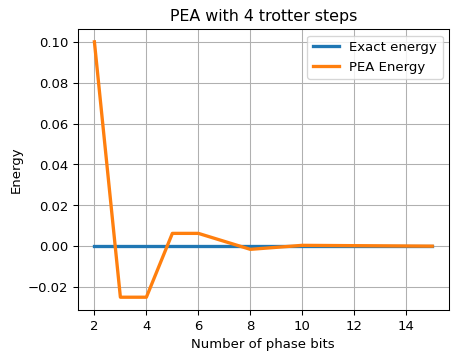

In [3]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Set up the parameters to be investigated
expected_energy = 0
target_energy = expected_energy + 0.1
size_interval = 1
n_phase_bits_list = [2, 3, 4, 5, 6, 8, 10, 15]
n_trotter_list = [4]

# Running PEA and plotting
gs = GridSpec(2, 2)
plt.figure(figsize=(9, 7), dpi=95)
linewidth = 2.5
for ind, n_trotter_steps in enumerate(n_trotter_list):
    energies_list = []
    plt.subplot(gs[ind])
    plt.title(r"PEA with %s trotter steps" % n_trotter_steps)
    for nqbits_phase in n_phase_bits_list:
        energy, prob = perform_phase_estimation(
            hamilt,
            nqbits_phase,
            n_trotter_steps,
            E_target=target_energy,
            size_interval=size_interval,
            qpu=qpu,
        )
        energies_list.append(energy)

    plt.plot(
        n_phase_bits_list,
        expected_energy * np.ones(len(n_phase_bits_list)),
        linewidth=linewidth,
        label="Exact energy",
    )
    plt.plot(n_phase_bits_list, energies_list, linewidth=linewidth, label="PEA Energy")
    plt.grid()
    plt.xlabel("Number of phase bits")
    plt.ylabel("Energy")
    plt.legend(loc="best")
plt.tight_layout()

## Influence of the initial vector

The PEA should be given an initial vector that is an eigenvector of the Hamiltonian. Let us see what happens if we start from every one of the possible $2^4 = 16$ states, most of which are actually not eigenvectors:

In [4]:
from itertools import product

# Set up the parameters to be investigated
expected_energy = 0
target_energy = expected_energy + 0.1
size_interval = 5  # enclose all eigenvalues around target_energy
n_phase_bits = 1
n_trotter_steps = 1

# Running PEA
energies_list = []
# print(eigvals)
for init_vec in product("01", repeat=4):
    init_vec = "".join(init_vec)
    energy, prob = perform_phase_estimation(
        hamilt,
        nqbits_phase,
        n_trotter_steps,
        init_vec=init_vec,
        E_target=target_energy,
        size_interval=size_interval,
        qpu=qpu,
    )
    #     print(init_vec, energy)
    energies_list.append(energy)

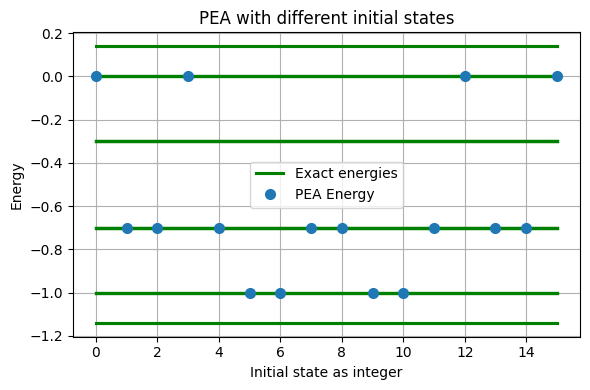

In [5]:
# Plotting
init_vecs_int = np.arange(0, 16, 1)
plt.figure(figsize=(6, 4), dpi=100)
plt.title("PEA with different initial states")
for ind, expected_energy in enumerate(eigvals):
    plt.plot(
        init_vecs_int,
        expected_energy * np.ones(len(init_vecs_int)),
        "g",
        linewidth=2.25,
        label=None if ind != len(eigvals) - 1 else "Exact energies",
    )
plt.plot(init_vecs_int, energies_list, "o", markersize=7, label="PEA Energy")
plt.grid()
plt.xlabel("Initial state as integer")
plt.ylabel("Energy")
plt.legend(loc="best")
plt.tight_layout()

We can see that we are not able to reach all eigenvalues. However, if we could provide a routine to prepare the ground state, we would get the corresponding lowest energy.

## Other important factors

The choice of `E_target` and the `size_interval`, denoted $\Delta$, are crucial for the QPE to output a meaningful result. These two define the window in which an energy will be searched:

$$(E_{target} - \frac{\Delta}{2}, E_{target} + \frac{\Delta}{2})$$

If the function is asked to find the energy outside this range, the output will be unreliable. This is most often observed when small changes in the target energy or the size-interval cause considerable changes in the result. Therefore, it is advisable to always start from a reasonably large range and shrink afterwards to get a better precision of a (stable) energy already found.

## Extract the circuit for the QPE routine

One can use the function `build_qpe_routine_for_hamiltonian` to extract the circuit corresponding to the QPE. This function needs a Hamiltonian in the qubit basis, which one can obtain by transforming the `ElectronicStructureHamiltonian` we started from via for example the transformation `transform_to_jw_basis`.

Depth of PEA routine = 29


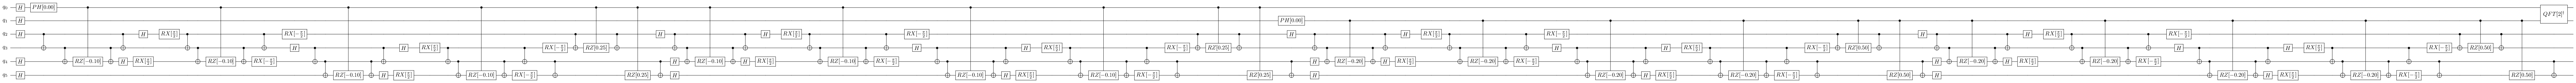

In [6]:
from qat.fermion.phase_estimation import build_qpe_routine_for_hamiltonian
from qat.fermion.transforms import transform_to_jw_basis

H_qubit_basis = transform_to_jw_basis(hamilt)
n_phase_bits = 2
n_trotter_steps = 2
routine = build_qpe_routine_for_hamiltonian(H_qubit_basis, n_phase_bits, n_trotter_steps=n_trotter_steps)

print("Depth of PEA routine =", len(routine))
routine.display()